# User2 Apple Health Data Exploration

This notebook explores the Apple Health export data for User2 to understand:
- Number and types of workouts
- Heart rate data availability and quality
- GPS tracking characteristics
- Temporal distribution of workouts
- Data quality metrics

In [1]:
#!/usr/bin/env python3
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add parser to path
sys.path.append(str(Path.cwd()))
from parse_apple_health import AppleHealthParser, GPXParser

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Setup Paths and Load Data

In [2]:
# Define paths
base_dir = Path("/home/riccardo/Documents/Collaborative-Projects/SUB_3H_42KM_DL/DATA/apple_health_export_User2")
export_xml = base_dir / "export.xml"
workout_routes_dir = base_dir / "workout-routes"

print(f"Base directory: {base_dir}")
print(f"Export XML exists: {export_xml.exists()}")
print(f"Workout routes directory exists: {workout_routes_dir.exists()}")

# Count GPX files
gpx_files = list(workout_routes_dir.glob("*.gpx"))
print(f"\nTotal GPX files: {len(gpx_files)}")

Base directory: /home/riccardo/Documents/Collaborative-Projects/SUB_3H_42KM_DL/DATA/apple_health_export_User2
Export XML exists: True
Workout routes directory exists: True

Total GPX files: 627


In [3]:
# Initialize parser
print("Initializing Apple Health parser...")
parser = AppleHealthParser(str(export_xml), str(base_dir))
print("✓ Parser initialized successfully")

Initializing Apple Health parser...
✓ Parser initialized successfully


## 2. Parse Workouts Metadata

In [4]:
# Parse all workouts
print("Parsing workouts from XML...")
workouts = parser.parse_workouts()
print(f"✓ Found {len(workouts)} total workouts\n")

# Convert to DataFrame
workouts_data = []
for w in workouts:
    workouts_data.append({
        'workout_type': w.activity_type,
        'start_date': w.start_date,
        'end_date': w.end_date,
        'duration_min': w.duration_min,
        'distance_km': w.total_distance_km,
        'energy_kcal': w.total_energy_kcal,
        'gpx_file': w.gpx_file_path
    })

df_workouts = pd.DataFrame(workouts_data)
df_workouts['start_date'] = pd.to_datetime(df_workouts['start_date'])
df_workouts['has_gpx'] = df_workouts['gpx_file'].notna()

print("Workout Types Distribution:")
print(df_workouts['workout_type'].value_counts())

Parsing workouts from XML...
Parsing workouts from /home/riccardo/Documents/Collaborative-Projects/SUB_3H_42KM_DL/DATA/apple_health_export_User2/export.xml...
  Parsed 50 running workouts...
  Parsed 100 running workouts...
  Parsed 150 running workouts...
  Parsed 200 running workouts...
✓ Found 209 running workouts
✓ Found 209 total workouts

Workout Types Distribution:
workout_type
HKWorkoutActivityTypeRunning    209
Name: count, dtype: int64


## 3. Focus on Running Workouts

In [5]:
# Filter running workouts
df_runs = df_workouts[df_workouts['workout_type'].str.contains('Running', case=False, na=False)].copy()
df_runs_gpx = df_runs[df_runs['has_gpx']].copy()

print(f"Total Running Workouts: {len(df_runs)}")
print(f"Running Workouts with GPX: {len(df_runs_gpx)} ({100*len(df_runs_gpx)/len(df_runs):.1f}%)")

# Basic statistics
print("\n" + "="*60)
print("RUNNING WORKOUTS SUMMARY (with GPX)")
print("="*60)
print(f"\nTotal runs: {len(df_runs_gpx)}")
print(f"Date range: {df_runs_gpx['start_date'].min().date()} to {df_runs_gpx['start_date'].max().date()}")
print(f"\nDuration (minutes):")
print(df_runs_gpx['duration_min'].describe())
print(f"\nDistance (km):")
print(df_runs_gpx['distance_km'].describe())
print(f"\nEnergy (kcal):")
print(df_runs_gpx['energy_kcal'].describe())

Total Running Workouts: 209
Running Workouts with GPX: 191 (91.4%)

RUNNING WORKOUTS SUMMARY (with GPX)

Total runs: 191
Date range: 2024-07-16 to 2025-11-25

Duration (minutes):
count     191.000000
mean       58.789648
std       218.980496
min         1.445512
25%        26.966922
50%        40.183339
75%        55.140395
max      3053.333333
Name: duration_min, dtype: float64

Distance (km):
count    191.000000
mean       6.788513
std        3.523427
min        0.004965
25%        4.584775
50%        6.097140
75%        8.808415
max       19.841300
Name: distance_km, dtype: float64

Energy (kcal):
count    184.000000
mean     335.475340
std      181.203845
min        1.085210
25%      219.389750
50%      294.524000
75%      437.835750
max      996.494000
Name: energy_kcal, dtype: float64


## 4. Temporal Distribution

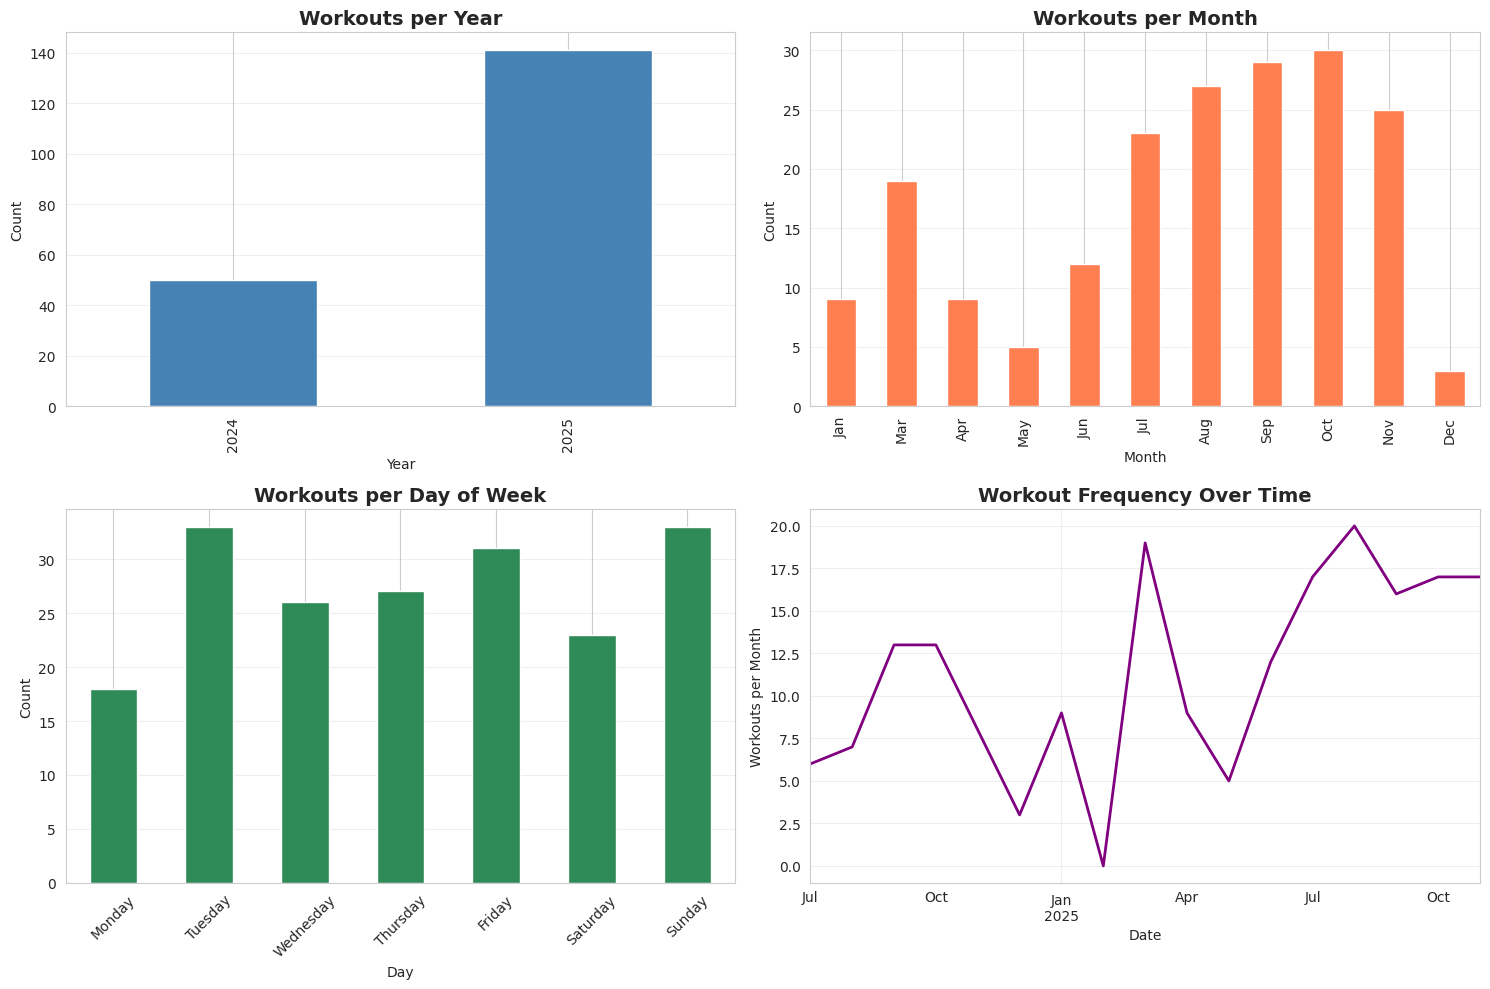

In [6]:
# Extract temporal features
df_runs_gpx['year'] = df_runs_gpx['start_date'].dt.year
df_runs_gpx['month'] = df_runs_gpx['start_date'].dt.month
df_runs_gpx['day_of_week'] = df_runs_gpx['start_date'].dt.day_name()

# Plot temporal distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Runs per year
df_runs_gpx['year'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Workouts per Year', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Count')
axes[0,0].grid(axis='y', alpha=0.3)

# Runs per month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts = df_runs_gpx['month'].value_counts().sort_index()
month_counts.index = [month_names[i-1] for i in month_counts.index]
month_counts.plot(kind='bar', ax=axes[0,1], color='coral')
axes[0,1].set_title('Workouts per Month', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Count')
axes[0,1].grid(axis='y', alpha=0.3)

# Runs per day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_runs_gpx['day_of_week'].value_counts().reindex(day_order)
day_counts.plot(kind='bar', ax=axes[1,0], color='seagreen')
axes[1,0].set_title('Workouts per Day of Week', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Day')
axes[1,0].set_ylabel('Count')
axes[1,0].grid(axis='y', alpha=0.3)
axes[1,0].tick_params(axis='x', rotation=45)

# Timeline
df_runs_gpx.set_index('start_date').resample('M').size().plot(ax=axes[1,1], color='purple', linewidth=2)
axes[1,1].set_title('Workout Frequency Over Time', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Workouts per Month')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Distance and Duration Analysis

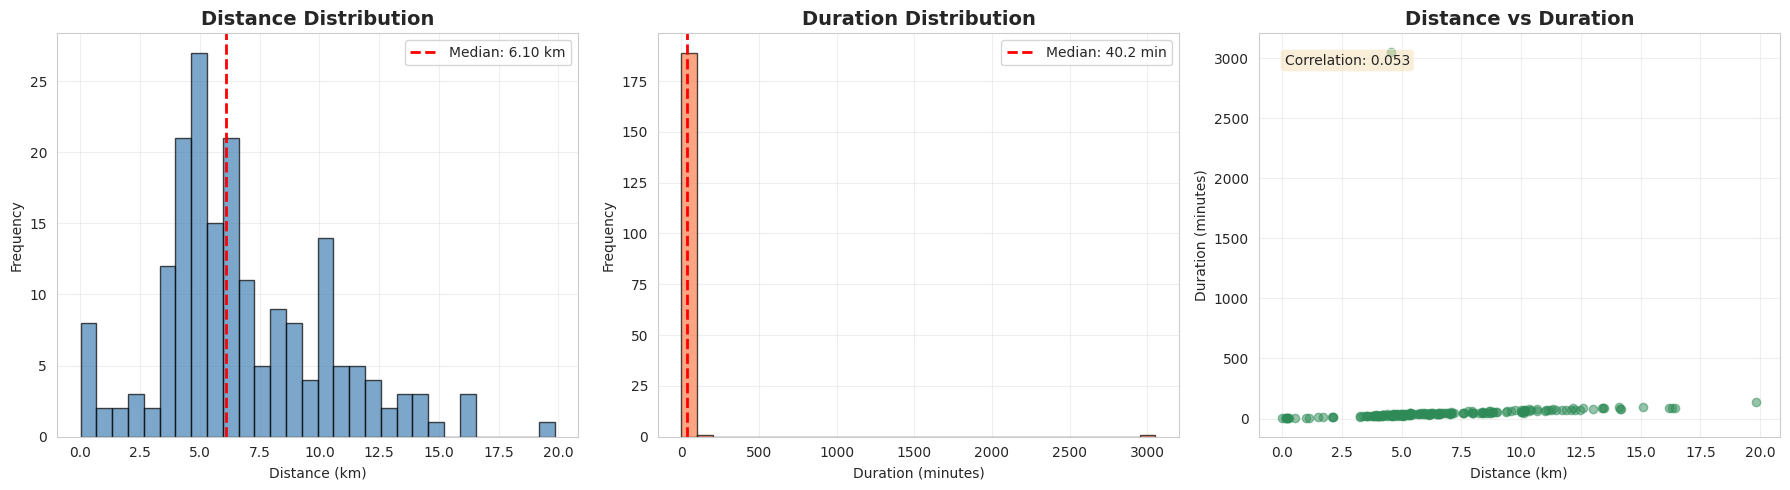

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distance distribution
axes[0].hist(df_runs_gpx['distance_km'].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df_runs_gpx['distance_km'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df_runs_gpx["distance_km"].median():.2f} km')
axes[0].set_title('Distance Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Duration distribution
axes[1].hist(df_runs_gpx['duration_min'].dropna(), bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(df_runs_gpx['duration_min'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df_runs_gpx["duration_min"].median():.1f} min')
axes[1].set_title('Duration Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Distance vs Duration scatter
axes[2].scatter(df_runs_gpx['distance_km'], df_runs_gpx['duration_min'], alpha=0.5, color='seagreen')
axes[2].set_title('Distance vs Duration', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Distance (km)')
axes[2].set_ylabel('Duration (minutes)')
axes[2].grid(alpha=0.3)

# Add correlation
corr = df_runs_gpx[['distance_km', 'duration_min']].corr().iloc[0,1]
axes[2].text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes[2].transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 6. Sample GPX File Analysis

In [9]:
# Pick a sample GPX file (one with medium duration)
sample_workout = df_runs_gpx.sort_values('duration_min').iloc[len(df_runs_gpx)//2]
sample_gpx_path = base_dir / sample_workout['gpx_file'].lstrip('/')

print(f"Analyzing sample workout:")
print(f"  Date: {sample_workout['start_date']}")
print(f"  Duration: {sample_workout['duration_min']:.1f} minutes")
print(f"  Distance: {sample_workout['distance_km']:.2f} km")
print(f"  GPX file: {sample_gpx_path.name}")

# Parse GPX
gpx_parser = GPXParser(str(sample_gpx_path))
trackpoints = gpx_parser.parse_trackpoints()

print(f"\n  GPS trackpoints: {len(trackpoints)}")
print(f"  Sampling rate: {len(trackpoints)/sample_workout['duration_min']:.1f} points/minute")

# Convert to DataFrame
gps_data = []
for tp in trackpoints:
    gps_data.append({
        'timestamp': tp.timestamp,
        'lat': tp.lat,
        'lon': tp.lon,
        'elevation': tp.elevation,
        'speed': tp.speed,
        'course': tp.course
    })

df_gps = pd.DataFrame(gps_data)
df_gps['timestamp'] = pd.to_datetime(df_gps['timestamp']).dt.tz_localize(None)
df_gps = df_gps.sort_values('timestamp').reset_index(drop=True)

print(f"\nGPS Data Sample:")
print(df_gps.head())
print(f"\nGPS Data Info:")
print(df_gps.describe())

Analyzing sample workout:
  Date: 2025-10-07 07:01:47
  Duration: 40.2 minutes
  Distance: 6.07 km
  GPX file: route_2025-10-07_8.41am.gpx

  GPS trackpoints: 2412
  Sampling rate: 60.0 points/minute

GPS Data Sample:
            timestamp        lat       lon  elevation  speed course
0 2025-10-07 06:01:46  47.239970 -1.560311  25.108530    0.0   None
1 2025-10-07 06:01:47  47.239966 -1.560303  25.088082    0.0   None
2 2025-10-07 06:01:48  47.239961 -1.560294  25.067448    0.0   None
3 2025-10-07 06:01:49  47.239956 -1.560286  25.046123    0.0   None
4 2025-10-07 06:01:50  47.239948 -1.560277  25.024551    0.0   None

GPS Data Info:
                           timestamp          lat          lon    elevation  \
count                           2412  2412.000000  2412.000000  2412.000000   
mean   2025-10-07 06:21:52.348673280    47.237326    -1.551539     7.364321   
min              2025-10-07 06:01:46    47.227333    -1.560311    -4.140678   
25%    2025-10-07 06:11:49.750000128    47

## 7. Visualize Sample GPS Track

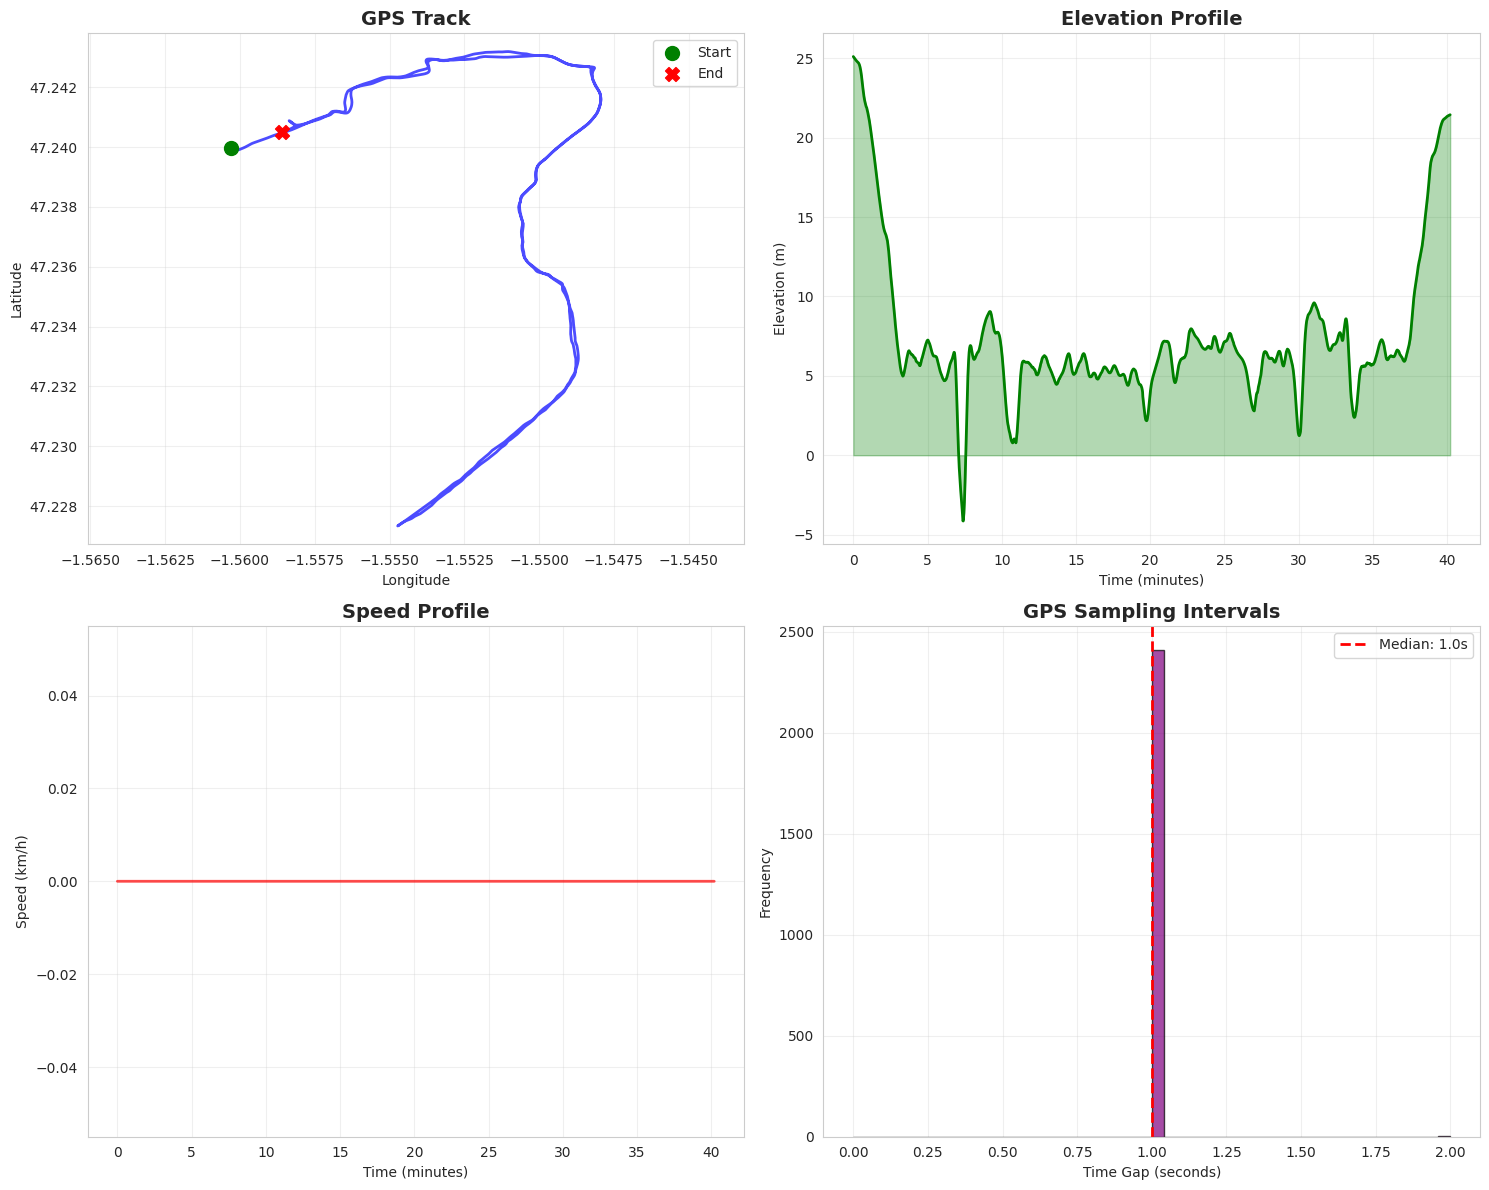


GPS Sampling Statistics:
  Median interval: 1.0 seconds
  Mean interval: 1.0 seconds
  Max gap: 2.0 seconds


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# GPS route on map
axes[0,0].plot(df_gps['lon'], df_gps['lat'], 'b-', linewidth=2, alpha=0.7)
axes[0,0].scatter(df_gps['lon'].iloc[0], df_gps['lat'].iloc[0], color='green', s=100, marker='o', label='Start', zorder=5)
axes[0,0].scatter(df_gps['lon'].iloc[-1], df_gps['lat'].iloc[-1], color='red', s=100, marker='X', label='End', zorder=5)
axes[0,0].set_title('GPS Track', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)
axes[0,0].axis('equal')

# Elevation profile
time_minutes = (df_gps['timestamp'] - df_gps['timestamp'].min()).dt.total_seconds() / 60
axes[0,1].plot(time_minutes, df_gps['elevation'], 'g-', linewidth=2)
axes[0,1].fill_between(time_minutes, df_gps['elevation'], alpha=0.3, color='green')
axes[0,1].set_title('Elevation Profile', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Time (minutes)')
axes[0,1].set_ylabel('Elevation (m)')
axes[0,1].grid(alpha=0.3)

# Speed profile (if available)
if df_gps['speed'].notna().any():
    speed_kmh = df_gps['speed'] * 3.6  # m/s to km/h
    axes[1,0].plot(time_minutes, speed_kmh, 'r-', linewidth=2, alpha=0.7)
    axes[1,0].set_title('Speed Profile', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Time (minutes)')
    axes[1,0].set_ylabel('Speed (km/h)')
    axes[1,0].grid(alpha=0.3)
else:
    axes[1,0].text(0.5, 0.5, 'No speed data available', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Speed Profile', fontsize=14, fontweight='bold')

# Data quality: time gaps
time_diffs = df_gps['timestamp'].diff().dt.total_seconds()
axes[1,1].hist(time_diffs.dropna(), bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1,1].set_title('GPS Sampling Intervals', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Time Gap (seconds)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(time_diffs.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {time_diffs.median():.1f}s')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nGPS Sampling Statistics:")
print(f"  Median interval: {time_diffs.median():.1f} seconds")
print(f"  Mean interval: {time_diffs.mean():.1f} seconds")
print(f"  Max gap: {time_diffs.max():.1f} seconds")

## 8. Heart Rate Data Analysis

Parsing heart rate data for sample workout...
  Time range: 2025-10-07 07:01:47 to 2025-10-07 07:41:58.000316
  Heart rate records: 523
  HR sampling rate: 13.0 samples/minute

Heart Rate Statistics:
count    523.000000
mean     150.378511
std       14.535302
min       40.961100
25%      150.000000
50%      154.000000
75%      156.000000
max      175.000000
Name: heart_rate, dtype: float64


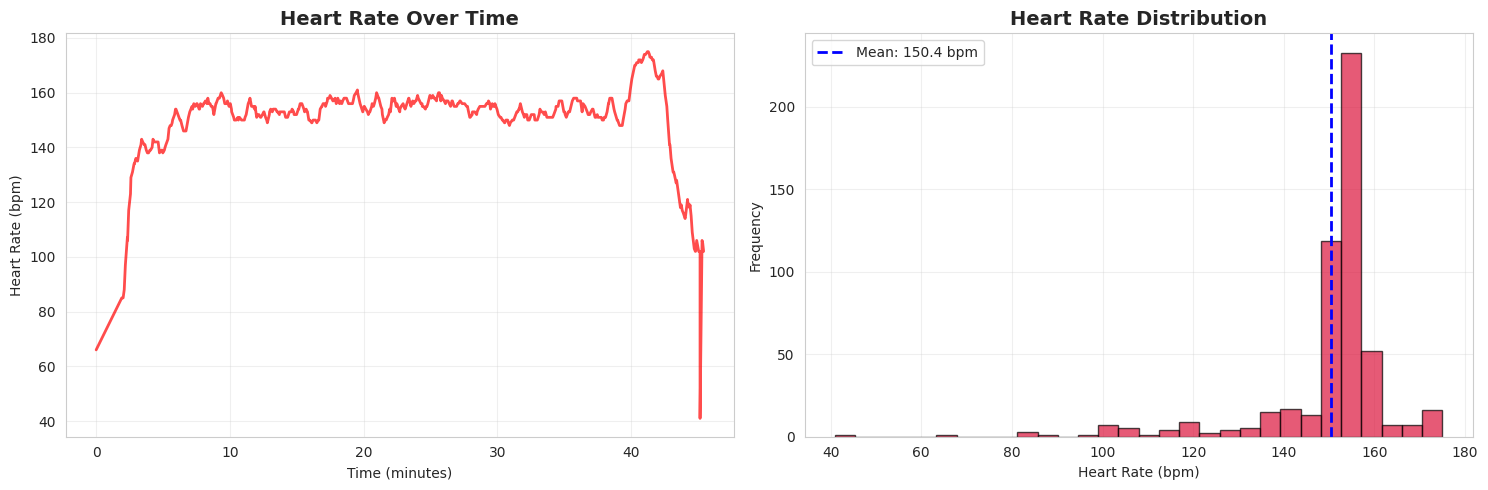

In [11]:
# Parse heart rate data for sample workout
start_date = sample_workout['start_date'].to_pydatetime()
end_date = sample_workout['start_date'] + pd.Timedelta(minutes=sample_workout['duration_min'])
end_date = end_date.to_pydatetime()

print(f"Parsing heart rate data for sample workout...")
print(f"  Time range: {start_date} to {end_date}")

hr_records = parser.parse_heart_rate_records(start_date, end_date)

print(f"  Heart rate records: {len(hr_records)}")
print(f"  HR sampling rate: {len(hr_records)/sample_workout['duration_min']:.1f} samples/minute")

if len(hr_records) > 0:
    # Convert to DataFrame
    hr_data = [{'timestamp': hr.timestamp, 'heart_rate': hr.value} for hr in hr_records]
    df_hr = pd.DataFrame(hr_data)
    df_hr['timestamp'] = pd.to_datetime(df_hr['timestamp']).dt.tz_localize(None)
    df_hr = df_hr.sort_values('timestamp').reset_index(drop=True)
    
    print(f"\nHeart Rate Statistics:")
    print(df_hr['heart_rate'].describe())
    
    # Plot heart rate
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    time_hr = (df_hr['timestamp'] - df_hr['timestamp'].min()).dt.total_seconds() / 60
    axes[0].plot(time_hr, df_hr['heart_rate'], 'r-', linewidth=2, alpha=0.7)
    axes[0].set_title('Heart Rate Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time (minutes)')
    axes[0].set_ylabel('Heart Rate (bpm)')
    axes[0].grid(alpha=0.3)
    
    axes[1].hist(df_hr['heart_rate'], bins=30, color='crimson', edgecolor='black', alpha=0.7)
    axes[1].axvline(df_hr['heart_rate'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {df_hr["heart_rate"].mean():.1f} bpm')
    axes[1].set_title('Heart Rate Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Heart Rate (bpm)')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No heart rate data found for this workout")

## 9. Heart Rate Quality Across All Workouts

Analyzing heart rate quality across workouts...
(Sampling 50 workouts for speed)

Heart Rate Quality Distribution:
  GOOD    :  29 ( 58.0%)
  MEDIUM  :  12 ( 24.0%)
  SPARSE  :   7 ( 14.0%)
  NONE    :   2 (  4.0%)


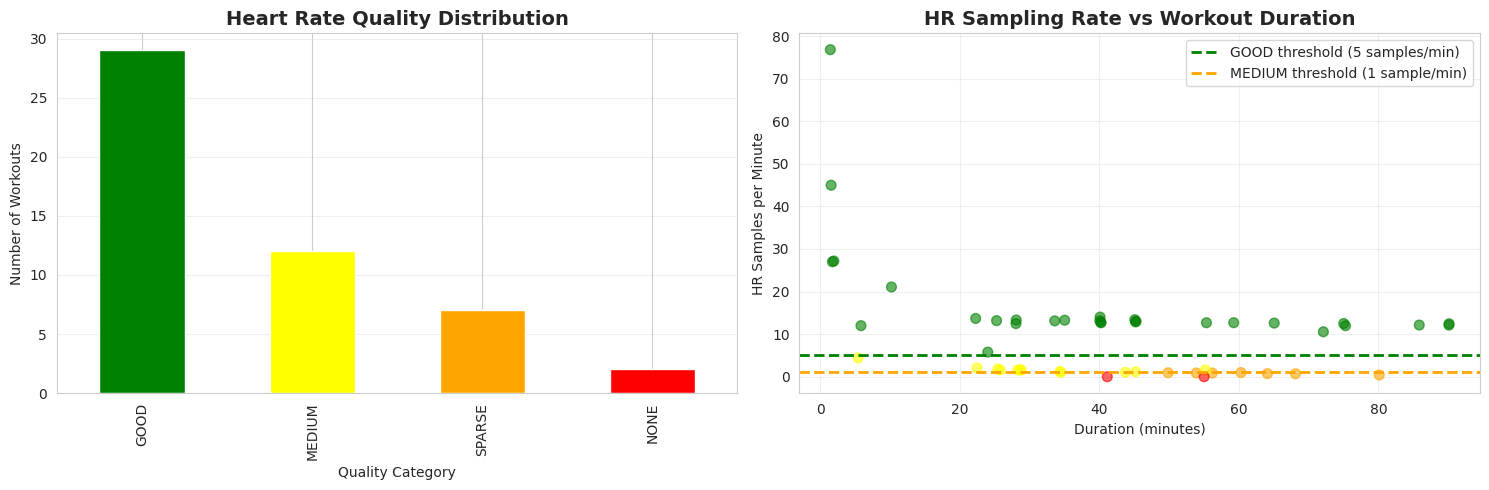

In [12]:
# Analyze HR quality for a sample of workouts
print("Analyzing heart rate quality across workouts...")
print("(Sampling 50 workouts for speed)\n")

sample_size = min(50, len(df_runs_gpx))
sample_workouts = df_runs_gpx.sample(n=sample_size, random_state=42)

hr_quality_data = []
for idx, workout in sample_workouts.iterrows():
    start = workout['start_date'].to_pydatetime()
    end = (workout['start_date'] + pd.Timedelta(minutes=workout['duration_min'])).to_pydatetime()
    
    try:
        hr_recs = parser.parse_heart_rate_records(start, end)
        samples_per_min = len(hr_recs) / workout['duration_min'] if workout['duration_min'] > 0 else 0
        
        if samples_per_min >= 5:
            quality = 'GOOD'
        elif samples_per_min >= 1:
            quality = 'MEDIUM'
        elif samples_per_min > 0:
            quality = 'SPARSE'
        else:
            quality = 'NONE'
        
        hr_quality_data.append({
            'duration_min': workout['duration_min'],
            'distance_km': workout['distance_km'],
            'hr_count': len(hr_recs),
            'hr_samples_per_min': samples_per_min,
            'quality': quality
        })
    except Exception as e:
        continue

df_hr_quality = pd.DataFrame(hr_quality_data)

print("Heart Rate Quality Distribution:")
quality_counts = df_hr_quality['quality'].value_counts()
for q in ['GOOD', 'MEDIUM', 'SPARSE', 'NONE']:
    count = quality_counts.get(q, 0)
    pct = 100 * count / len(df_hr_quality) if len(df_hr_quality) > 0 else 0
    print(f"  {q:8s}: {count:3d} ({pct:5.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

quality_counts.plot(kind='bar', ax=axes[0], color=['green', 'yellow', 'orange', 'red'])
axes[0].set_title('Heart Rate Quality Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Quality Category')
axes[0].set_ylabel('Number of Workouts')
axes[0].grid(axis='y', alpha=0.3)

axes[1].scatter(df_hr_quality['duration_min'], df_hr_quality['hr_samples_per_min'], 
                c=df_hr_quality['quality'].map({'GOOD': 'green', 'MEDIUM': 'yellow', 'SPARSE': 'orange', 'NONE': 'red'}),
                s=50, alpha=0.6)
axes[1].axhline(y=5, color='green', linestyle='--', linewidth=2, label='GOOD threshold (5 samples/min)')
axes[1].axhline(y=1, color='orange', linestyle='--', linewidth=2, label='MEDIUM threshold (1 sample/min)')
axes[1].set_title('HR Sampling Rate vs Workout Duration', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Duration (minutes)')
axes[1].set_ylabel('HR Samples per Minute')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Data Quality Summary

In [13]:
print("="*80)
print("USER2 DATA QUALITY SUMMARY")
print("="*80)

print(f"\n📊 WORKOUTS")
print(f"  Total workouts: {len(df_workouts)}")
print(f"  Running workouts: {len(df_runs)} ({100*len(df_runs)/len(df_workouts):.1f}%)")
print(f"  Running workouts with GPX: {len(df_runs_gpx)} ({100*len(df_runs_gpx)/len(df_runs):.1f}%)")

print(f"\n📍 GPS DATA")
print(f"  Total GPX files: {len(gpx_files)}")
print(f"  Average GPS points per workout: ~{len(trackpoints)} (based on sample)")
print(f"  GPS sampling rate: ~{len(trackpoints)/sample_workout['duration_min']:.1f} points/minute")

print(f"\n❤️  HEART RATE DATA (based on {sample_size} workout sample)")
good_quality = (df_hr_quality['quality'] == 'GOOD').sum()
medium_quality = (df_hr_quality['quality'] == 'MEDIUM').sum()
usable = good_quality + medium_quality
print(f"  GOOD quality: {good_quality} ({100*good_quality/len(df_hr_quality):.1f}%)")
print(f"  MEDIUM quality: {medium_quality} ({100*medium_quality/len(df_hr_quality):.1f}%)")
print(f"  Usable (GOOD+MEDIUM): {usable} ({100*usable/len(df_hr_quality):.1f}%)")

print(f"\n📅 TEMPORAL COVERAGE")
print(f"  Date range: {df_runs_gpx['start_date'].min().date()} to {df_runs_gpx['start_date'].max().date()}")
days_span = (df_runs_gpx['start_date'].max() - df_runs_gpx['start_date'].min()).days
print(f"  Time span: {days_span} days ({days_span/365:.1f} years)")
print(f"  Average workouts per month: {len(df_runs_gpx) / (days_span/30):.1f}")

print(f"\n🏃 WORKOUT CHARACTERISTICS")
print(f"  Average distance: {df_runs_gpx['distance_km'].mean():.2f} km")
print(f"  Average duration: {df_runs_gpx['duration_min'].mean():.1f} minutes")
print(f"  Distance range: {df_runs_gpx['distance_km'].min():.2f} - {df_runs_gpx['distance_km'].max():.2f} km")
print(f"  Duration range: {df_runs_gpx['duration_min'].min():.1f} - {df_runs_gpx['duration_min'].max():.1f} minutes")

print("\n" + "="*80)
print("✅ User2 data appears to be suitable for heart rate prediction modeling!")
print("="*80)

USER2 DATA QUALITY SUMMARY

📊 WORKOUTS
  Total workouts: 209
  Running workouts: 209 (100.0%)
  Running workouts with GPX: 191 (91.4%)

📍 GPS DATA
  Total GPX files: 627
  Average GPS points per workout: ~2412 (based on sample)
  GPS sampling rate: ~60.0 points/minute

❤️  HEART RATE DATA (based on 50 workout sample)
  GOOD quality: 29 (58.0%)
  MEDIUM quality: 12 (24.0%)
  Usable (GOOD+MEDIUM): 41 (82.0%)

📅 TEMPORAL COVERAGE
  Date range: 2024-07-16 to 2025-11-25
  Time span: 496 days (1.4 years)
  Average workouts per month: 11.6

🏃 WORKOUT CHARACTERISTICS
  Average distance: 6.79 km
  Average duration: 58.8 minutes
  Distance range: 0.00 - 19.84 km
  Duration range: 1.4 - 3053.3 minutes

✅ User2 data appears to be suitable for heart rate prediction modeling!


## 11. Next Steps

Based on this exploration:

1. **Process all workouts**: Run `process_all_workouts.py` (modified for User2 paths)
2. **Filter by quality**: Keep workouts with GOOD or MEDIUM heart rate quality
3. **Align GPS and HR**: Use timezone correction for proper alignment
4. **Feature engineering**: Calculate speed, pace, grade from GPS
5. **Merge with existing dataset**: Combine User2 data with other users for model training